In [19]:
import glob
import random
import matplotlib.pyplot as plt


def get_random_image(dir, condition):
    type_of_image = {"n": "NORMAL", "p": "PNEUMONIA"}

    placeholder = type_of_image.get(condition)
    if placeholder is None:
        raise Exception("Unknown condition")
            
    folder = f"./data/chest_xray/{dir}/{placeholder}/*.jpeg"  
    image_paths = glob.glob(folder)
    max_length = len(image_paths)
    random_number = random.randint(0, max_length)
    for index, item in enumerate(image_paths, start=1):
        if index == random_number:
            print(index,item)
            image = plt.imread(item)
            ready_image=plt.imshow(image)
            plt.show()
            return ready_image


1102 ./data/chest_xray/train/PNEUMONIA/person1398_bacteria_3548.jpeg


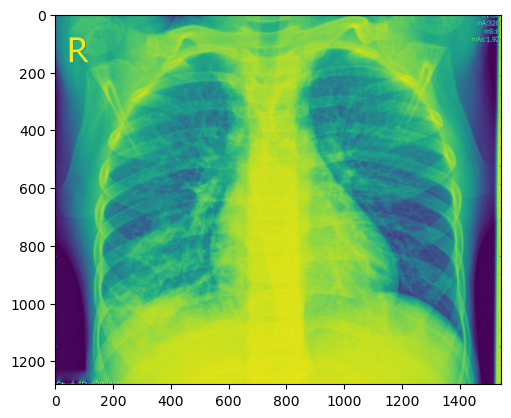

In [20]:
get_random_image("train","p")